In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras import backend as K
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet', include_top=False)
x = [l for l in model.layers]
layer_name = x[1].name
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [4]:
# 경사상승법을 구현하기 위해 모델의 입력에 대한 손실의 그레디언트가 필요
grads = K.gradients(loss, model.input)[0]

In [5]:
# 그래디언트 정규화
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [6]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [7]:
# 확률적 경사상승법을 구성
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  input_img_data += grads_value * step

In [8]:
# 텐서를 이미지 형태로 변환하는 유틸리티 함수
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [9]:
# 필터 시각화 이미지를 만드는 함수
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
  img = input_img_data[0]
  return deprocess_image(img)

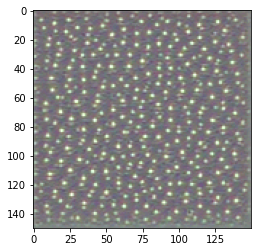

In [12]:
plt.imshow(generate_pattern('block3_conv1', 0))

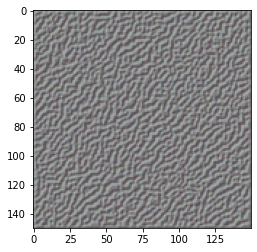

In [13]:
plt.imshow(generate_pattern(layer_name,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


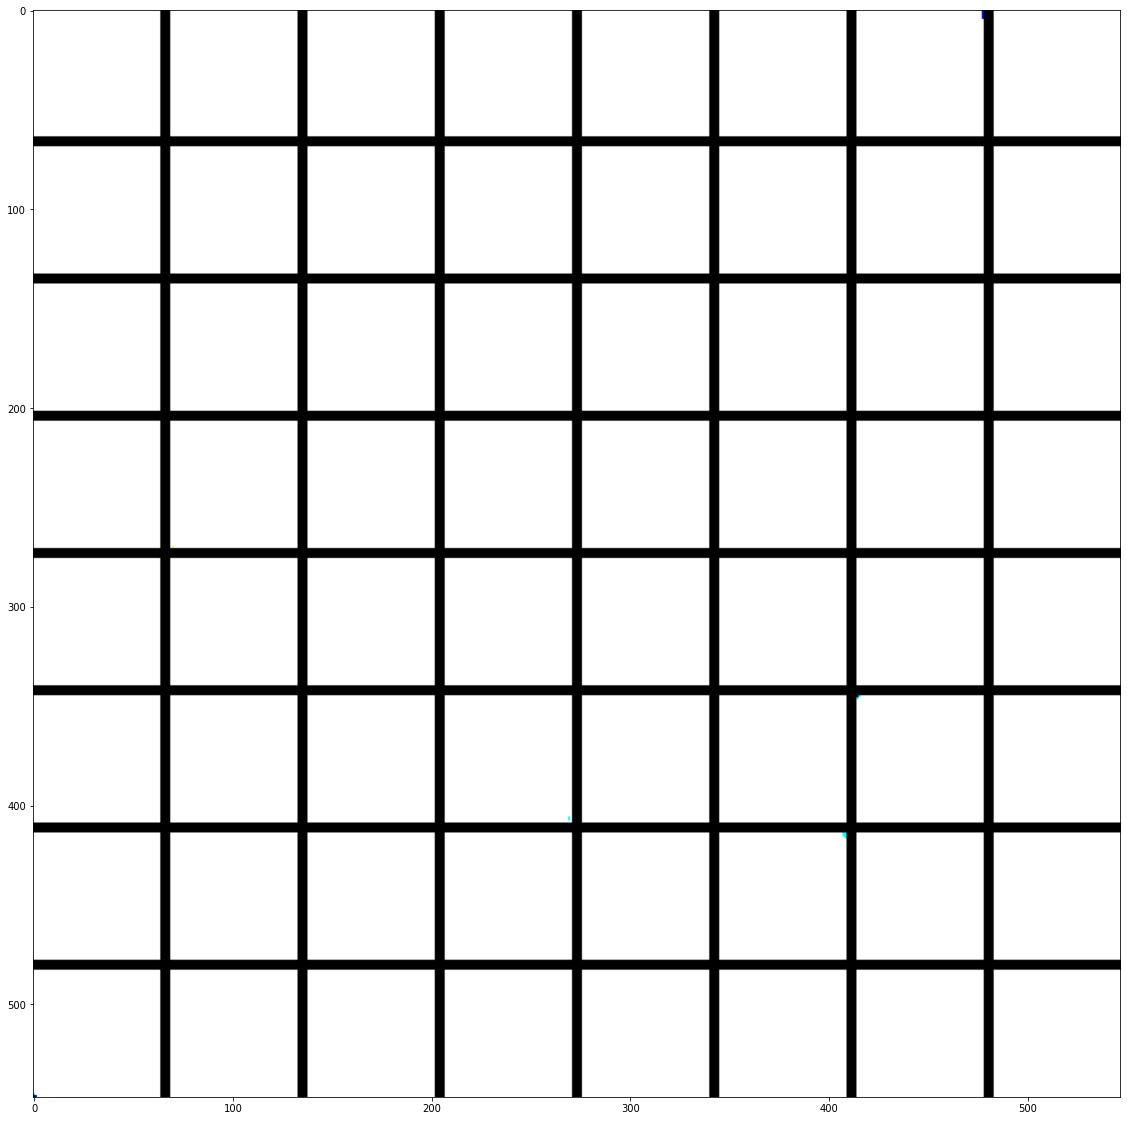

In [14]:
# 층에 있는 각 필터에 반응하는 패턴 생성
size = 64
margin = 5
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)